In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from scipy.sparse import coo_matrix
import scipy.sparse.linalg as spla
from scipy import integrate 
from scipy.integrate import dblquad

1. **Géométrie.**  

Nous considérons le domaine suivant

$$
\Omega:=((0, 2\pi) \times (0,2\pi)) \backslash ([\pi /2, 3\pi /2]),
$$

avec la frontiè $Γ = Γ_{N} ∪ Γ_{D}$ désigne la frontière de $(0, 2\pi) \times (0, 2\pi)$ et $Γ_{D}$ désigne la frontière de $(\pi /2, 3\pi /2) \times (\pi /2, 3 \pi /2)$.

------

(a) Écrire une routine **GenerateMesh** adaptée de celle du TP2 qui génère un maillage triangulaire structuré uniforme pour $\Omega$. Les sorties sont: vtx(tableau de coordonnées) et elt(tableau de conectivité) pour le maillage du domaine $\Omega$ au format du TP2. Le maillage doit être construit en générant d'abord un maillage triangulaire uniforme du carré complet $(0, 2\pi) \times (0, 2\pi)$. Le nombre de points dans chaque direction doit être de la forme $N = (4n+1)$ avec $n \in \mathbb{N}$. En suite, les nœuds et les triangles (ouverts) ayant une intersection non triviale avec le carré $(\pi /2, 3\pi /2) \times (\pi /2, 3\pi /2)$ doivent être supprimés. Voir la Figure 2. Les indices des nœuds et des éléments doivent être mis à jour, de. sorte que les indices des nœuds vont de 0 à $N_{\Omega} - 1$ où $N_{\Omega}$ est le nombre de nœuds dans le maillage de $\Omega$.

In [2]:
def GenerateMesh(n):
    
    N = 4 * n + 1
    x = np.linspace(0, 2*np.pi, N)
    y = np.linspace(0, 2*np.pi, N)
    xx, yy = np.meshgrid(x, y)
    points = np.column_stack([xx.ravel(), yy.ravel()])

    def node_index(i, j):
        return i * N + j

    elements = []
    for i in range(N-1):
        for j in range(N-1):
            p1 = node_index(i, j)
            p2 = node_index(i, j+1)
            p3 = node_index(i+1, j)
            p4 = node_index(i+1, j+1)
            elements.append([p1, p2, p4])
            elements.append([p1, p4, p3])

    vtx = points
    elt = np.array(elements)

    x_in = (vtx[:, 0] >= np.pi/2) & (vtx[:, 0] <= 3*np.pi/2)
    y_in = (vtx[:, 1] >= np.pi/2) & (vtx[:, 1] <= 3*np.pi/2)
    bad_nodes = np.where(x_in & y_in)[0]
    
    
    bad_node_set = set(bad_nodes)
    keep_mask = []
    for tri in elt:
        if all(v in bad_node_set for v in tri):
            keep_mask.append(False)
        else:
            keep_mask.append(True)
    elt = elt[np.array(keep_mask)]

    used_nodes = np.unique(elt)
    new_indices = -np.ones(len(vtx), dtype=int)
    new_indices[used_nodes] = np.arange(len(used_nodes))
    vtx = vtx[used_nodes]
    elt = new_indices[elt]

    return vtx, elt

-----

(b) Écrire une routine PlotMesh qui peut représenter un maillage triangulaire du domaine $\Omega$ et tracer le nouveau maillage.

In [3]:
# Dessiner une grille triangulaire structurée
def PlotMesh(vtx, elt):
    triangulation = mtri.Triangulation(vtx[:,0], vtx[:,1], elt)
    plt.figure(figsize=(6,6))
    plt.triplot(triangulation, color='gray')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Triangular Mesh of Ω')
    plt.gca().set_aspect('equal')
    plt.show()

----

(c) Adapter la routine précédente pour représenter le vecteur unitaire normal sortant **n** sur toute la frontière $Γ$ de $\Omega$.

In [4]:
def plot_boundary_normals(vtx, elt):
    edges = set()
    for tri in elt:
        for i in range(3):
            edge = tuple((tri[i], tri[(i+1)%3]))
            edge_swapped = (edge[1], edge[0])
            edges.add(edge)
            if edge_swapped in edges:
                edges.remove(edge_swapped)  
                edges.remove(edge)
            
    edge_list = np.array(list(edges))
    midpoints = (vtx[edge_list[:,0]] + vtx[edge_list[:,1]]) / 2
    tangents = vtx[edge_list[:,1]] - vtx[edge_list[:,0]]
    normals = np.column_stack([tangents[:,1], -tangents[:,0]])
    norms = np.linalg.norm(normals, axis=1, keepdims=True)
    normals /= norms

    plt.figure(figsize=(6,6))
    plt.triplot(vtx[:,0], vtx[:,1], elt, color='gray')
    plt.quiver(midpoints[:,0], midpoints[:,1], normals[:,0], normals[:,1],
               color='red', scale=20)
    plt.title("Unit Outward Normals on Boundary")
    plt.gca().set_aspect('equal')
    plt.show()

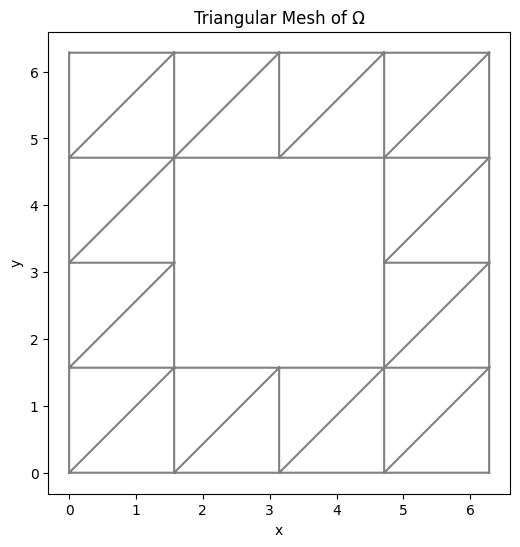

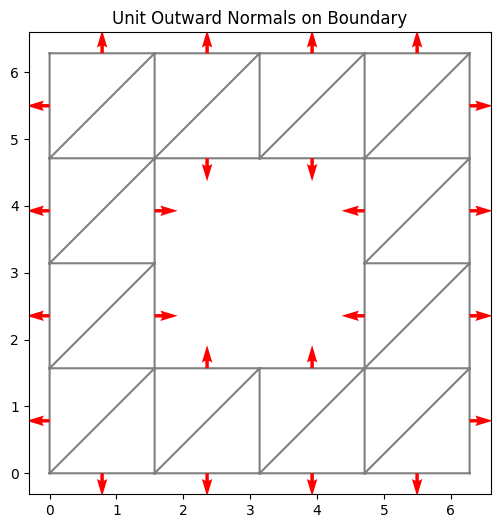

In [5]:
n = 1
vtx, elt = GenerateMesh(n)
PlotMesh(vtx, elt)
plot_boundary_normals(vtx, elt)

<hr style="border:1px dashed black;">

**2.Problème d'EDP.**  

Rappelons que $Γ_{N}$ désigne la frontière de $(0,2\pi)\times (0,2\pi)$ et $Γ_{D}$ désigne la frontière de $(\pi/2, 3\pi/2) \times (\pi/2, 3\pi/2)$. Soit
$$
μ（x,y):=
\left\{
\begin{array}{l}
1, \ si \ y < \pi,\\ 
2, \ si \ y > \pi.
\end{array}
\right.
$$
Soit $p,q \in \mathbb{N}$,
$$
f(x,y) := (4(p^2 + q^2) + \mu)\ sin(2px)\ sin(2qy),\ \ \ \forall (x,y)\in \Omega,\\ 
u_{ex}(x,y):= sin(2px)\ sin(2qy),\ \ \ \forall (x,y) \in \Omega .
$$

Nous considérons le modèle d'EDP du second ordre suivant:

$$
\left\{
\begin{array}{l}
Trouver\ u\in H^1(\Omega)\ tel\ que:\\ 
-\Delta u+\mu u = f,\ \ \ \ \ \ dans\ \Omega,\\
u = 0,\ \ \ \ \ \ \ \ \ \ \ \  \ \ \ sur\ Γ_{D},\\ 
\partial_nu = \partial_n u_{ex},\ \ \ \ \ \ \ \ sur\ Γ_{N}.
\end{array}
\right.
$$

Nous voulons calculer une solution approchée $u_h$ du problème ci-dessus en utilisant une méthode de Galerkin conforme. L'espace d'approximation de dimension finie $V_h$ est construit en utilisant des éléments finis de Lagrange $\mathbb{P}_1$ sur des maillages triangulaires.


In [6]:
# fonctions utilisées
def mu(x, y):
    if y < np.pi:
        return 1
    else:
        return 2

def f(x, y, p, q, mu=mu):
    return (4*(p**2+q**2)+mu(x,y)) * np.sin(2*p*x) * np.sin(2*q*y)

def u_ex_fct(x, y, p, q):
    return np.sin(2*p*x) * np.sin(2*q*y)


# donner le résultat de \partial_n u_ex sur le point (x,y) au bord
def g(x, y, p, q):
    
    if y==0:
        return -2*q*np.sin(2*p*x)
    elif x==2*np.pi:
        return 2*p*np.cos(4*p*np.pi)*np.sin(2*q*y)
    elif y==2*np.pi:
        return 2*q*np.sin(2*p*x)
    else:
        return -2*p*np.sin(2*q*y)

    
    
# Sélectionner les arêtes situées sur le bord.
def Boundary_edge(vtx, elt):
    
    edges = set()
    edges_bord_N = []
    edges_bord_D = []
    
    for tri in elt:
        for i in range(3):
            edge = tuple((tri[i], tri[(i+1)%3]))
            edge_swapped = (edge[1], edge[0])
            edges.add(edge)
            if edge_swapped in edges:
                edges.remove(edge_swapped)  
                edges.remove(edge)
                
    edge_list = np.array(list(edges))
    
    for edge in edge_list:
        index_A = edge[0]
        index_B = edge[1]
        
        if vtx[index_A][1]==0 and vtx[index_B][1]==0:
            edges_bord_N.append(edge)
        elif vtx[index_A][0]==0 and vtx[index_B][0]==0:
            edges_bord_N.append(edge)
        elif vtx[index_A][0]==2*np.pi and vtx[index_B][0]==2*np.pi:
            edges_bord_N.append(edge)
        elif vtx[index_A][1]==2*np.pi and vtx[index_B][1]==2*np.pi:
            edges_bord_N.append(edge)
        else:
            edges_bord_D.append(edge)
            
    return edges_bord_N, edges_bord_D

----

(a) Écrire la formulation variationnelle associée à (5).

$V = \{ v \in H^1(\Omega)$ telle que $v = 0$ sur $ Γ_{D} \}$

Trouver $u \in V$ telle que pour tout $v \in V$, on a que
$$
\int_\Omega \nabla u \cdot \nabla v + \mu u \overline{v} = \int_\Omega f \overline{v} + \int_{\Gamma_N} \partial_n u_{\text{ex}} \overline{v}
$$

----

(b) Écrire deux routines pour assembler les matrices élémentaires associées à chaque terme apparaissant dans la forme bilinéaire pour la méthode numérique considérée, sur le modèle de ce qui a été fait dans le TP5.

In [7]:
def Kloc(vtx, e):
    
    # vtx: les coordonnées de tous les points
    # e: liste, index de trois sommets dans vtx; une élément de elt
    
    coords = vtx[e]
    
    x = coords[:,0] 
    y = coords[:,1]  
    area = 0.5 * abs((x[1]-x[0])*(y[2]-y[0]) - (x[2]-x[0])*(y[1]-y[0]))

    grad_phi = np.zeros((3, 2))  
    for i in range(3):
        j = (i+1) % 3
        k = (i+2) % 3
        grad_phi[i,:] = [y[j] - y[k], x[k] - x[j]] / (2 * area)

    K = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            K[i,j] = np.dot(grad_phi[i], grad_phi[j]) * area
            
    return K

In [8]:
def Mloc_mu(vtx, e):
    
    # vtx: les coordonnées de tous les points
    # e: liste, index de trois sommets dans vtx; une élément de elt
    
    coords = vtx[e]
    
    # calculer l'aire d'élément triangulaire
    x = coords[:,0]  # 三个顶点的横坐标列表
    y = coords[:,1]  # 三个顶点的纵坐标列表
    area = 0.5 * abs((x[1]-x[0])*(y[2]-y[0]) - (x[2]-x[0])*(y[1]-y[0]))
    
    y_avg = np.mean(coords[:,1])
    mu = 1 if y_avg < np.pi else 2
    M = (mu * area / 12.0) * np.array([[2,1,1],
                                       [1,2,1],
                                       [1,1,2]])
    return M

----

(c) Écrire la routine pour assembler la matrice complète du système linéaire associé.

In [9]:
def Matrice_globale(vtx, elt):

    m = len(vtx)
    I, J, K_data, M_data = [], [], [], []

    for e in elt:
        Ke = Kloc(vtx, e)
        Me = Mloc_mu(vtx, e)
        for i_local, i_global in enumerate(e):
            for j_local, j_global in enumerate(e):
                I.append(i_global)
                J.append(j_global)
                K_data.append(Ke[i_local, j_local])
                M_data.append(Me[i_local, j_local])

    K = coo_matrix((K_data, (I, J)), shape=(m, m))
    M = coo_matrix((M_data, (I, J)), shape=(m, m))
    A = K + M
    
    boundary_edges_D = Boundary_edge(vtx, elt)[1]
    points_D = np.unique(boundary_edges_D)
    for i in points_D:
        A[i, :]=0
        A[i, i]=1
    
    return A

-----

(d) Écrire une routine pour assembler (une approximation numérique du) terme associé à la condition aux limites de Neumann pour le vecteur membre de droite du système linéaire.

In [10]:
def assemble_b_N(vtx, elt, g_N, p, q):
    
    boundary_edges_N = Boundary_edge(vtx, elt)[0]

    N = vtx.shape[0]
    b_N = np.zeros(N)

    for edge_AB in boundary_edges_N:
        
        index_A = edge_AB[0]
        index_B = edge_AB[1]
        
        
        A, B = vtx[index_A], vtx[index_B]
        edge_vec = B - A
        edge_length = np.linalg.norm(edge_vec)
        midpoint = 0.5 * (A + B)

        normal = np.array([edge_vec[1], -edge_vec[0]])  # rotate 90°
        normal /= np.linalg.norm(normal)

        g_val = g_N(midpoint[0], midpoint[1], p, q)

        contribution = 0.5 * g_val * edge_length
        b_N[index_A] += contribution
        b_N[index_B] += contribution

    return b_N

-----

(e) Écrire une routine pour assembler (une approximation numérique du) terme associé à la source $f$ pour le vecteur du membre de droite du système linéaire.

In [11]:
def assemble_b_f(vtx, elt, f, p, q):
    
    N = vtx.shape[0]
    b_f = np.zeros(N)

    for tri in elt:
        A, B, C = vtx[tri[0]], vtx[tri[1]], vtx[tri[2]]
        area = 0.5 * abs(np.linalg.det(np.array([[B[0]-A[0], C[0]-A[0]],
                                                 [B[1]-A[1], C[1]-A[1]]])))
        G = (A + B + C) / 3  # barycenter
        f_val = f(G[0], G[1], p, q)

        for local_i, global_i in enumerate(tri):
            b_f[global_i] += f_val * area / 3.0

    return b_f

<hr style="border:1px dashed black;">

**3. Résolution.**

----

(a) Vérifier que $u_{ex}$ est la solution exacte du problème. (Regarder dans le rapport)

-----

(b) Résoudre numériquement (5)

In [12]:
# Par exemple n = 50, p = 1, q = 1
n = 50
p = 1
q = 1
vtx, elt = GenerateMesh(n)


def globale_numérique(n, f, g, p, q):
    
    vtx, elt = GenerateMesh(n)
    A = Matrice_globale(vtx, elt)
    b_N = assemble_b_N(vtx, elt, g, p, q)
    b_f = assemble_b_f(vtx, elt, f, p, q)
    b = b_N + b_f

    boundary_edges_D = Boundary_edge(vtx, elt)[1]
    points_D = np.unique(boundary_edges_D)
    for i in points_D:
        b[i]=0
    
    uh = spla.spsolve(A, b)
    return uh

uh = globale_numérique(n, f, g, p, q)

/Users/extraodinaire/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


------

(c) Écrire une routine PlotApproximation qui peut représenter un champ affine par morceaux $v_h \in V_h$ dans le domaine $\Omega$ pour un certain maillage triangulaire. En utilisant cette routine, représentez la solution numérique $u_h$ de la question précédente et l'erreur associée $u_h - \prod_h u_{ex}$, où $\prod_h$ est l'opérateur d'interpolation global.

In [13]:
def PlotApproximation(vtx, elt, uh, title):
    triang = mtri.Triangulation(vtx[:, 0], vtx[:, 1], elt)
    plt.figure(figsize=(8,6))
    plt.tricontourf(triang, uh, levels=50, cmap='viridis')
    plt.colorbar(label="Value")
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

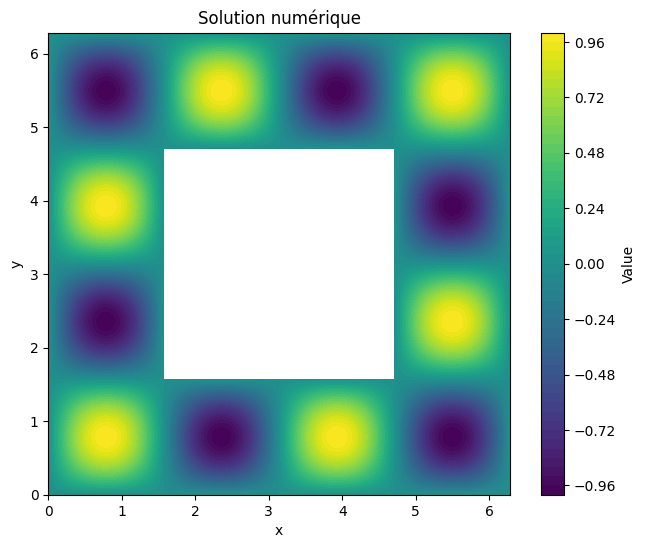

In [14]:
PlotApproximation(vtx, elt, uh, 'Solution numérique')

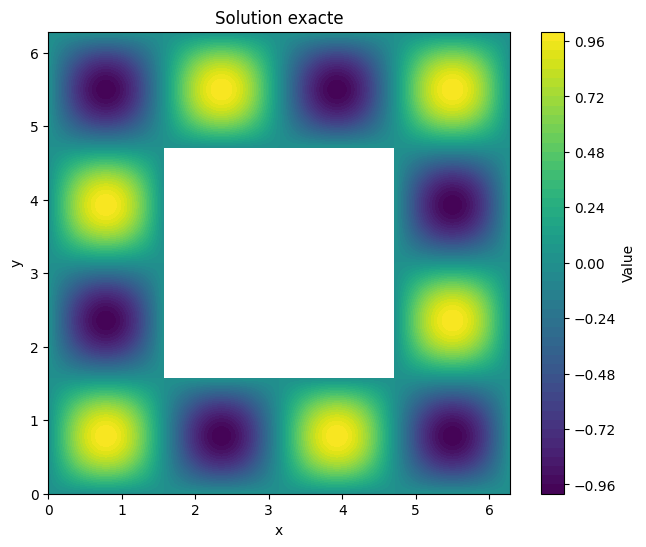

In [15]:
uh_exacte = []
for (x, y) in vtx:
    u_ex = u_ex_fct(x, y, p, q)
    uh_exacte.append(u_ex)
PlotApproximation(vtx, elt, uh_exacte, title='Solution exacte')

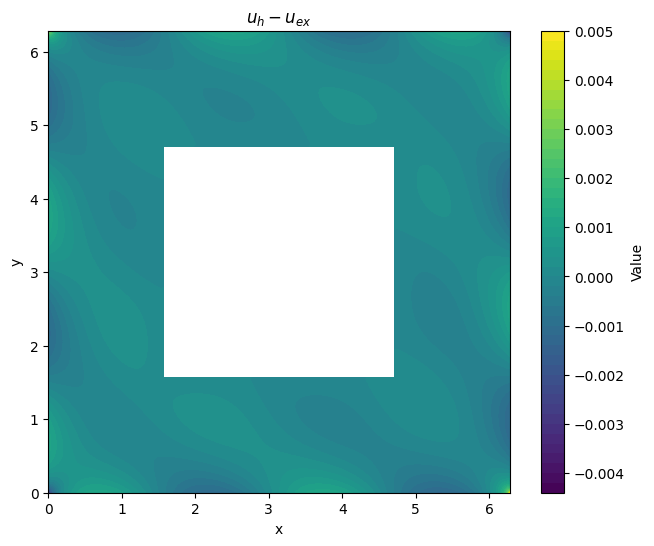

In [16]:
PlotApproximation(vtx, elt, uh - uh_exacte, title='$u_h-u_{ex}$')

In [17]:
# donner les bases dans un élément local s_i
def base_phi_A_si(i, x, y, vtx, elt):
    index_A, index_B, index_C = elt[i]
    x0, y0 = vtx[index_A]
    x1, y1 = vtx[index_B]
    x2, y2 = vtx[index_C]
    
    aire = 0.5*np.abs((x1-x0)*(y2-y0)-(x2-x0)*(y1-y0))
    
    a0 = (y2-y1)/(2*aire)
    b0 = (x1-x2)/(2*aire)
    c0 = (x2*y1 - x1*y2)/(2*aire)
    
    return a0*x + b0*y + c0


def base_phi_B_si(i, x, y, vtx, elt):
    index_A, index_B, index_C = elt[i]
    x0, y0 = vtx[index_A]
    x1, y1 = vtx[index_B]
    x2, y2 = vtx[index_C]
    
    aire = 0.5*np.abs((x1-x0)*(y2-y0)-(x2-x0)*(y1-y0))
    
    a1 = (y0-y2)/(2*aire)
    b1 = (x2-x0)/(2*aire)
    c1 = (x0*y2 - x2*y0)/(2*aire)
    
    return a1*x + b1*y + c1


def base_phi_C_si(i, x, y, vtx, elt):
    index_A, index_B, index_C = elt[i]
    x0, y0 = vtx[index_A]
    x1, y1 = vtx[index_B]
    x2, y2 = vtx[index_C]
    
    aire = 0.5*np.abs((x1-x0)*(y2-y0)-(x2-x0)*(y1-y0))
    
    a2 = (y1-y0)/(2*aire)
    b2 = (x0-x1)/(2*aire)
    c2 = (x1*y0 - x0*y1)/(2*aire)
    
    return a2*x + b2*y + c2


    
def gradient_Ai(i, x, y, vtx, elt):
    index_A, index_B, index_C = elt[i]
    x0, y0 = vtx[index_A]
    x1, y1 = vtx[index_B]
    x2, y2 = vtx[index_C]
    
    aire = 0.5*np.abs((x1-x0)*(y2-y0)-(x2-x0)*(y1-y0))
    
    a0 = (y2-y1)/(2*aire)
    b0 = (x1-x2)/(2*aire)
    c0 = (x2*y1 - x1*y2)/(2*aire)
    
    return a0, b0

def gradient_Bi(i, x, y, vtx, elt):
    index_A, index_B, index_C = elt[i]
    x0, y0 = vtx[index_A]
    x1, y1 = vtx[index_B]
    x2, y2 = vtx[index_C]
    
    aire = 0.5*np.abs((x1-x0)*(y2-y0)-(x2-x0)*(y1-y0))
    
    a1 = (y0-y2)/(2*aire)
    b1 = (x2-x0)/(2*aire)
    c1 = (x0*y2 - x2*y0)/(2*aire)
    
    return a1, b1


def gradient_Ci(i, x, y, vtx, elt):
    index_A, index_B, index_C = elt[i]
    x0, y0 = vtx[index_A]
    x1, y1 = vtx[index_B]
    x2, y2 = vtx[index_C]
    
    aire = 0.5*np.abs((x1-x0)*(y2-y0)-(x2-x0)*(y1-y0))
    
    a2 = (y1-y0)/(2*aire)
    b2 = (x0-x1)/(2*aire)
    c2 = (x1*y0 - x0*y1)/(2*aire)
    
    return a2, b2


In [18]:
def interpolation_u_si(vtx, elt, i, x, y, p, q):
    index_A_global = elt[i][0]
    index_B_global = elt[i][1]
    index_C_global = elt[i][2]
    
    coef_A = vtx[index_A_global]
    coef_B = vtx[index_B_global]
    coef_C = vtx[index_C_global]
    
    u_ex_A = u_ex_fct(coef_A[0], coef_A[1], p, q)
    u_ex_B = u_ex_fct(coef_B[0], coef_B[1], p, q)
    u_ex_C = u_ex_fct(coef_C[0], coef_C[1], p, q)
    
    return u_ex_A*base_phi_A_si(i,x,y,vtx,elt) + u_ex_B*base_phi_B_si(i,x,y,vtx,elt) + u_ex_C*base_phi_C_si(i,x,y,vtx,elt)

(d) Tracer la convergence des deux erreurs

$$
\frac{||u_h - \prod_h u_{ex}||_{L^2(\Omega)}}{||\prod_h u_{ex}||_{L^2(\Omega)}}, \frac{||u_h - \prod_h u_{ex}||_{H^1(\Omega)}}{||\prod_h u_{ex}||_{H^1(\Omega)}}
$$

par rapport au paramètre de maillage $h$ pour divers raffinements uniformes du maillage. Quel est l'ordre de convergence pour les deux erreurs?

In [19]:
def integral_triangle(f, A, B, C):
    
    # f est la fonction à faire l'intégrale
    # A, B, C sont trois sommets du triangle avec A = [xA,yA], B = [xB, yB], C = [xC,yC]
    
    def change_variable(r, s):
        x = A[0] + r*(B[0]-A[0]) + s*(C[0]-A[0])
        y = A[1] + r*(B[1]-A[1]) + s*(C[1]-A[1])
        return f(x, y)
    
    area = 0.5 * abs((B[0]-A[0])*(C[1]-A[1]) - (C[0]-A[0])*(B[1]-A[1]))
    
    def integral_sr(s, r):
        return change_variable(r, s)
    
    result, _ = dblquad(integral_sr, 0, 1, lambda r:0, lambda r: 1-r)
    
    return 2*area*result

In [20]:
def Erreur_norme2_globale(n, p, q, f, g):
    h = (np.sqrt(2)*np.pi) / (2*n)
    vtx, elt = GenerateMesh(n)
    Uh = globale_numérique(n, f, g, p, q)
    Norme_l2_carre_erreur = []
    Norme_l2_carre_interpolation = []
    
    for i in range(len(elt)):
        index_A, index_B, index_C = elt[i]
        x0, y0 = vtx[index_A]
        x1, y1 = vtx[index_B]
        x2, y2 = vtx[index_C]
        
        u_ex_A = u_ex_fct(x0, y0, p, q)
        u_ex_B = u_ex_fct(x1, y1, p, q)
        u_ex_C = u_ex_fct(x2, y2, p, q)
        
        def integral_i(x,y):
            return u_ex_A*base_phi_A_si(i,x,y,vtx,elt) + u_ex_B*base_phi_B_si(i,x,y,vtx,elt) + u_ex_C*base_phi_C_si(i,x,y,vtx,elt)
        
        norme_l2_interpo_local = integral_triangle(integral_i, vtx[index_A], vtx[index_B], vtx[index_C])**2
        Norme_l2_carre_interpolation.append(norme_l2_interpo_local)
        
        def integral_erreur_i(x,y):
            return (Uh[index_A]-u_ex_A)*base_phi_A_si(i,x,y,vtx,elt) + (Uh[index_B]-u_ex_B)*base_phi_B_si(i,x,y,vtx,elt) + (Uh[index_C]-u_ex_C)*base_phi_C_si(i,x,y,vtx,elt)
        
        erreur_l2_local = integral_triangle(integral_erreur_i, vtx[index_A], vtx[index_B], vtx[index_C])**2
        Norme_l2_carre_erreur.append(erreur_l2_local)
        
    norme_l2_interpo_global = np.sqrt(np.sum(Norme_l2_carre_interpolation))
    norme_l2_erreur_global = np.sqrt(np.sum(Norme_l2_carre_erreur))
    
    return norme_l2_erreur_global, norme_l2_interpo_global

In [21]:
def image_erreur_l2(N, p, q, f, g):
    fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi = 100)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_facecolor('lightyellow')
    Y_erreur = []
    Y_h2 = []
    X_h=[]
    for n in N:
        err=Erreur_norme2_globale(n, p, q, f, g)[0]
        interp = Erreur_norme2_globale(n, p, q, f, g)[1]
        Y_erreur.append(err/interp)
        h = (np.sqrt(2)*np.pi) / (2*n)
        Y_h2.append(h**2)
        X_h.append(h)
    plt.plot(X_h, Y_erreur,'--',label=" $||u - \pi_h u||_{L^2}$ ", color = "red", linewidth=3)
    plt.plot(X_h, Y_h2, label="$h^2$", color = 'blue', linewidth=3)
    plt.title("La relation entre erreur et pas h avec norme L2")
    plt.legend()
    plt.xlabel("h")
    plt.ylabel("Erreur")
    plt.show()

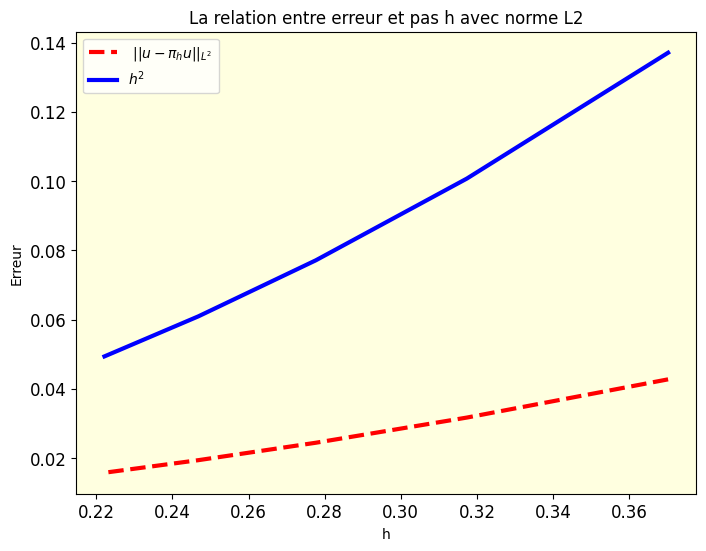

In [22]:
N = [6,7,8,9,10]
p = 1
q = 1
image_erreur_l2(N, p, q, f, g)

In [23]:
def image_erreur_l2_loglog(N, p, q, f, g):
    fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi = 100)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_facecolor('lightyellow')
    Y_erreur = []
    Y_h2 = []
    X_h=[]
    for n in N:
        err=Erreur_norme2_globale(n, p, q, f, g)[0]
        interp = Erreur_norme2_globale(n, p, q, f, g)[1]
        Y_erreur.append(err/interp)
        h = (np.sqrt(2)*np.pi) / (2*n)
        Y_h2.append(h**2)
        X_h.append(h)
    plt.loglog(X_h, Y_erreur,'--',label=" $||u - \pi_h u||_{L^2}$ ", color = "red", linewidth=3)
    plt.loglog(X_h, Y_h2, label="$h^2$", color = 'blue', linewidth=3)
    plt.title("La relation entre erreur et pas h avec norme L2")
    plt.legend()
    plt.xlabel("h")
    plt.ylabel("Erreur")
    plt.show()

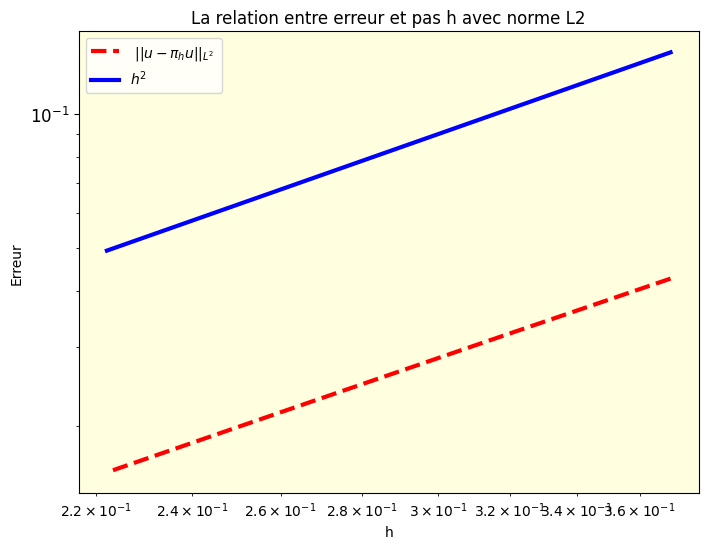

In [24]:
image_erreur_l2_loglog(N, p, q, f, g)

In [25]:
def Erreur_normeH1_globale(n, p, q, f, g):
    h = (np.sqrt(2)*np.pi) / (2*n)
    vtx, elt = GenerateMesh(n)
    Uh = globale_numérique(n, f, g, p, q)
    Norme_H1_carre_erreur = []
    Norme_H1_carre_interpolation = []
    
    for i in range(len(elt)):
        index_A, index_B, index_C = elt[i]
        x0, y0 = vtx[index_A]
        x1, y1 = vtx[index_B]
        x2, y2 = vtx[index_C]
        
        aire = 0.5*np.abs((x1-x0)*(y2-y0)-(x2-x0)*(y1-y0))
    
        a0 = (y2-y1)/(2*aire)
        b0 = (x1-x2)/(2*aire)
        a1 = (y0-y2)/(2*aire)
        b1 = (x2-x0)/(2*aire)
        a2 = (y1-y0)/(2*aire)
        b2 = (x0-x1)/(2*aire)
       
        
        u_ex_A = u_ex_fct(x0, y0, p, q)
        u_ex_B = u_ex_fct(x1, y1, p, q)
        u_ex_C = u_ex_fct(x2, y2, p, q)
        
        def integral_i(x,y):
            return u_ex_A*base_phi_A_si(i,x,y,vtx,elt) + u_ex_B*base_phi_B_si(i,x,y,vtx,elt) + u_ex_C*base_phi_C_si(i,x,y,vtx,elt)
        
        norme_l2_interpo_local = integral_triangle(integral_i, vtx[index_A], vtx[index_B], vtx[index_C])**2
        
        def integral_erreur_i(x,y):
            return (Uh[index_A]-u_ex_A)*base_phi_A_si(i,x,y,vtx,elt) + (Uh[index_B]-u_ex_B)*base_phi_B_si(i,x,y,vtx,elt) + (Uh[index_C]-u_ex_C)*base_phi_C_si(i,x,y,vtx,elt)
        
        erreur_l2_local = integral_triangle(integral_erreur_i, vtx[index_A], vtx[index_B], vtx[index_C])**2
       
        def integral_partial_i_x(x,y):
            return u_ex_A*a0 + u_ex_B*a1 + u_ex_C*a2
        
        norme_l2_partial_x = integral_triangle(integral_partial_i_x, vtx[index_A], vtx[index_B], vtx[index_C])**2
        
        def integral_partial_i_y(x,y):
            return u_ex_A*b0 + u_ex_B*b1 + u_ex_C*b2
        
        norme_l2_partial_y = integral_triangle(integral_partial_i_y, vtx[index_A], vtx[index_B], vtx[index_C])**2
        
        
        def integral_erreur_partial_i_x(x,y):
            return (Uh[index_A]-u_ex_A)*a0 + (Uh[index_B]-u_ex_B)*a1 + (Uh[index_C]-u_ex_C)*a2
    
        erreur_partial_x_local = integral_triangle(integral_erreur_partial_i_x, vtx[index_A], vtx[index_B], vtx[index_C])**2
    
        def integral_erreur_partial_i_y(x,y):
            return (Uh[index_A]-u_ex_A)*b0 + (Uh[index_B]-u_ex_B)*b1 + (Uh[index_C]-u_ex_C)*b2
    
        erreur_partial_y_local = integral_triangle(integral_erreur_partial_i_y, vtx[index_A], vtx[index_B], vtx[index_C])**2
    
        norme_H1_interpo_carre = norme_l2_interpo_local + norme_l2_partial_x +norme_l2_partial_y
        Norme_H1_carre_interpolation.append(norme_H1_interpo_carre)
        
        norme_H1_erreur_carre = erreur_l2_local + erreur_partial_x_local + erreur_partial_y_local
        Norme_H1_carre_erreur.append(norme_H1_erreur_carre)
        
        
    norme_H1_interpo_global = np.sqrt(np.sum(Norme_H1_carre_interpolation))
    norme_H1_erreur_global = np.sqrt(np.sum(Norme_H1_carre_erreur))
    
    return norme_H1_erreur_global, norme_H1_interpo_global

In [26]:
def image_erreur_H1(N, p, q, f, g):
    fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi = 100)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_facecolor('lightyellow')
    Y_erreur = []
    Y_h = []
    X_h=[]
    for n in N:
        err=Erreur_normeH1_globale(n, p, q, f, g)[0]
        interp = Erreur_normeH1_globale(n, p, q, f, g)[1]
        Y_erreur.append(err/interp)
        h = (np.sqrt(2)*np.pi) / (2*n)
        Y_h.append(h)
        X_h.append(h)
    plt.plot(X_h, Y_erreur,'--',label=" $||u - \pi_h u||_{H^1}$ ", color = "red", linewidth=3)
    plt.plot(X_h, Y_h, label="$h$", color = 'blue', linewidth=3)
    plt.title("La relation entre erreur et pas h avec norme H1")
    plt.legend()
    plt.xlabel("h")
    plt.ylabel("Erreur")
    plt.show()

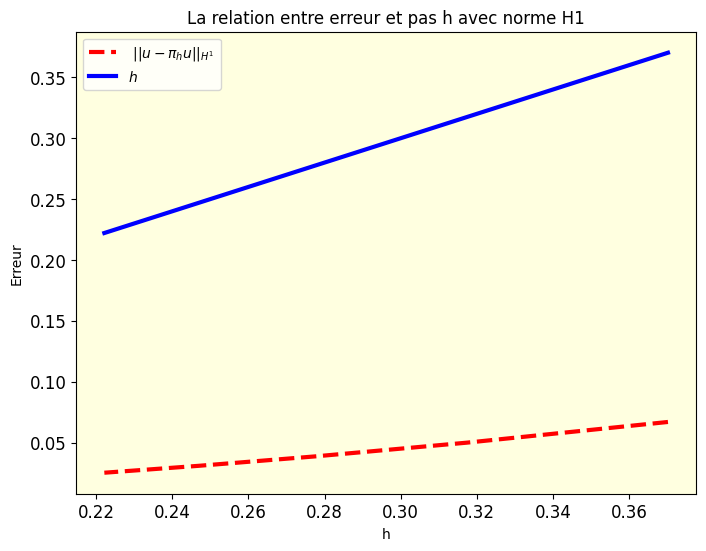

In [27]:
N = [6,7,8,9,10]
p = 1
q = 1
image_erreur_H1(N, p, q, f, g)

In [28]:
def image_erreur_H1_loglog(N, p, q, f, g):
    fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi = 100)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_facecolor('lightyellow')
    Y_erreur = []
    Y_h1 = []
    X_h=[]
    for n in N:
        err=Erreur_normeH1_globale(n, p, q, f, g)[0]
        interp = Erreur_normeH1_globale(n, p, q, f, g)[1]
        Y_erreur.append(err/interp)
        h = (np.sqrt(2)*np.pi) / (2*n)
        Y_h1.append(h)
        X_h.append(h)
    plt.loglog(X_h, Y_erreur,'--',label=" $log(||u - \pi_h u||_{H^1}) ", color = "red", linewidth=3)
    plt.loglog(X_h, Y_h1, label="$log(h)$", color = 'blue', linewidth=3)
    plt.title("La relation entre erreur et pas h avec norme H1")
    plt.legend()
    plt.xlabel("log(h)")
    plt.ylabel("log(Erreur)")
    plt.show()

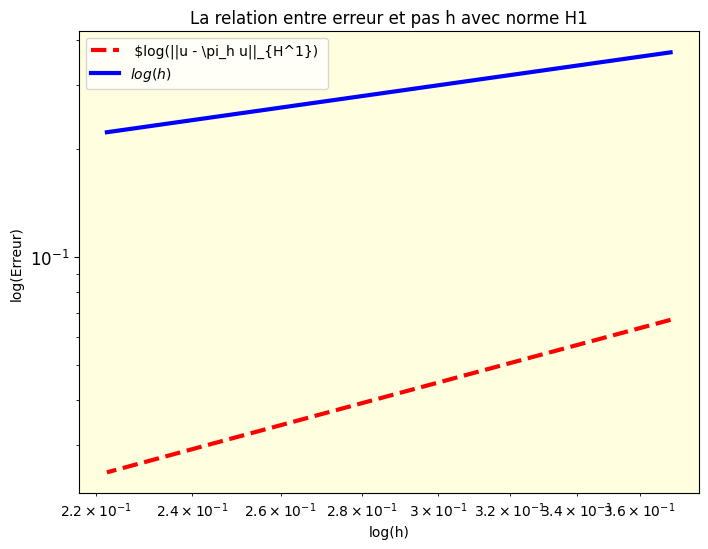

In [29]:
image_erreur_H1_loglog(N, p, q, f, g)

<hr style="border:1px dashed black;">